In [79]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

# Load all packages used
import matplotlib.pyplot as plt
import numpy as np
import mypackage

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
# # Load the real dataset
# X, Y, info = mypackage.Dataset.load("data/tomra", only_with_contaminant=True)
# X_train, X_test, Y_train, Y_test = mypackage.Dataset.train_test_split(X, Y, testRatio=0.3)

# X_test, X_train = mypackage.Dataset.scale(X_test, X_train, scale='GlobalCenterting')
# # X_test, X_train = mypackage.Dataset.PCA(X_test, X_train, n_components=3, plot=True, whiten=True)

# print(np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape)

### The fake dataset is by default a absorbance dataset. In order to use it as a pre-taining dataset for the TOMRA dataset, then either one of them need to converterd to absorbance or reflectance like the other.

In [146]:
# Setting the wavelengths to be the same as the real dataset collected at TOMRA

wavelengths = np.array([928, 932, 935, 939, 942, 946, 950, 953, 957, 960, 964, 968, 971, 975, 978, 982, 986, 989, 993, 997, 1000, 1004, 1007, 1011, 1015, 1018, 1022, 1025, 1029, 1033, 1036, 1040, 1043, 1047, 1051, 1054, 1058, 1061, 1065, 1069, 1072, 1076, 1079, 1083, 1087, 1090, 1094, 1097, 1101, 1105, 1108, 1112, 1115, 1119, 1123, 1126, 1130, 1134, 1137, 1141, 1144, 1148, 1152, 1155, 1159, 1162, 1166, 1170, 1173, 1177, 1180, 1184, 1188, 1191, 1195, 1198, 1202, 1206, 1209, 1213, 1216, 1220, 1224, 1227, 1231, 1234, 1238, 1242, 1245, 1249, 1252, 1256, 1260, 1263, 1267, 1271, 1274, 1278, 1281, 1285, 1289, 1292, 1296, 1299, 1303, 1307, 1310, 1314, 1317, 1321, 1325, 1328, 1332, 1335, 1339, 1343, 1346, 1350, 1353, 1357, 1361, 1364, 1368, 1371, 1375, 1379, 1382, 1386, 1390, 1393, 1397, 1400, 1404, 1408, 1411, 1415, 1418, 1422, 1426, 1429, 1433, 1436, 1440, 1444, 1447, 1451, 1454, 1458, 1462, 1465, 1469, 1472, 1476, 1480, 1483, 1487, 1490, 1494, 1498, 1501, 1505, 1508, 1512, 1516, 1519, 1523, 1527, 1530, 1534, 1537, 1541, 1545, 1548, 1552, 1555, 1559, 1563, 1566, 1570, 1573, 1577, 1581, 1584, 1588, 1591, 1595, 1599, 1602, 1606, 1609, 1613, 1617, 1620, 1624, 1627, 1631, 1635, 1638, 1642, 1645, 1649, 1653, 1656, 1660, 1664, 1667, 1671, 1674])

# The fake dataset is by default a absorbance dataset
fake_data = mypackage.FakeDataset(wavelengths=wavelengths)
X, Y = fake_data.get_images(50)

In [147]:
X_train, X_test, Y_train, Y_test = mypackage.Dataset.train_test_split(X, Y, testRatio=0.3)

X_test, X_train = mypackage.Dataset.scale(X_test, X_train, scale='GlobalStandardization')
# X_test, X_train = mypackage.Dataset.PCA(X_test, X_train, n_components=3, plot=True, whiten=True)

print(np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape)

[1 2] (15, 64, 64, 1) (-10.680117367209634, 1.6511396941425442) (15, 64, 64, 208)


In [148]:
def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(value=y_true, dtype=tf.float32)
        y_pred = tf.convert_to_tensor(value=y_pred, dtype=tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(input_tensor=fl, axis=1)
        return tf.reduce_mean(input_tensor=reduced_fl)
    return focal_loss_fixed

In [150]:
import tensorflow_addons as tfa
import tensorflow as tf
# fl = tfa.losses.SigmoidFocalCrossEntropy()
fl = focal_loss(alpha=1)

unet = mypackage.MyUnet.UNet(X_train, Y_train, loss_func=fl)
unet.train(batch_size=5, epochs=30, validation_split=0.1)
# unet.summary()

Train on 31 samples, validate on 4 samples
Epoch 1/30
31/31 [==============================] - 7s 212ms/step - loss: 0.4866 - accuracy: 0.6532 - val_loss: 0.1337 - val_accuracy: 0.5925

Epoch 00001: accuracy improved from -inf to 0.65319, saving model to best-model.hdf5
Epoch 2/30
31/31 [==============================] - 5s 171ms/step - loss: 0.2309 - accuracy: 0.6276 - val_loss: 0.1250 - val_accuracy: 0.6041

Epoch 00002: accuracy did not improve from 0.65319
Epoch 3/30
31/31 [==============================] - 5s 172ms/step - loss: 0.1648 - accuracy: 0.6290 - val_loss: 0.0974 - val_accuracy: 0.5999

Epoch 00003: accuracy did not improve from 0.65319
Epoch 4/30
31/31 [==============================] - 5s 174ms/step - loss: 0.1321 - accuracy: 0.6524 - val_loss: 0.0789 - val_accuracy: 0.5860

Epoch 00004: accuracy did not improve from 0.65319
Epoch 5/30
31/31 [==============================] - 5s 172ms/step - loss: 0.1125 - accuracy: 0.6975 - val_loss: 0.0746 - val_accuracy: 0.5545

Epoc

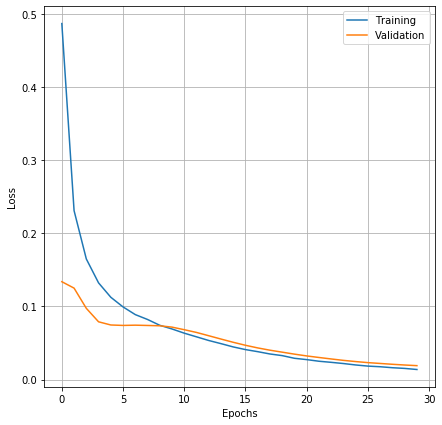

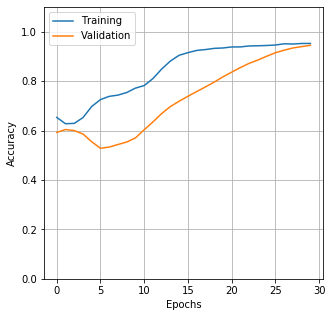

In [151]:
unet.plot_training_results()

              precision    recall  f1-score   support

           0       0.99      0.97      0.98    139145
           1       0.36      0.57      0.44      4215

    accuracy                           0.96    143360
   macro avg       0.67      0.77      0.71    143360
weighted avg       0.97      0.96      0.96    143360



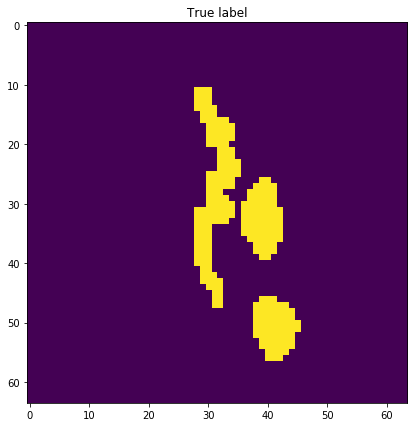

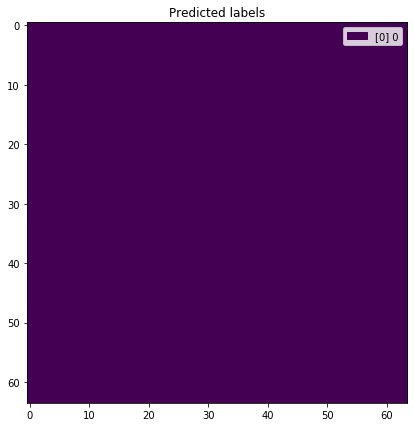

In [153]:
unet.predict(X_train, Y_labels=Y_train)

Train on 31 samples, validate on 4 samples
Epoch 1/30
31/31 [==============================] - 7s 219ms/step - loss: 0.6877 - accuracy: 0.5554 - val_loss: 0.7070 - val_accuracy: 0.4739

Epoch 00001: accuracy improved from -inf to 0.55542, saving model to best-model.hdf5
Epoch 2/30
31/31 [==============================] - 5s 169ms/step - loss: 0.6202 - accuracy: 0.7864 - val_loss: 0.7749 - val_accuracy: 0.3239

Epoch 00002: accuracy improved from 0.55542 to 0.78636, saving model to best-model.hdf5
Epoch 3/30
31/31 [==============================] - 5s 167ms/step - loss: 0.5746 - accuracy: 0.8837 - val_loss: 0.7922 - val_accuracy: 0.2380

Epoch 00003: accuracy improved from 0.78636 to 0.88374, saving model to best-model.hdf5
Epoch 4/30
31/31 [==============================] - 5s 166ms/step - loss: 0.5447 - accuracy: 0.9047 - val_loss: 0.7574 - val_accuracy: 0.2261

Epoch 00004: accuracy improved from 0.88374 to 0.90474, saving model to best-model.hdf5
Epoch 5/30
31/31 [==================

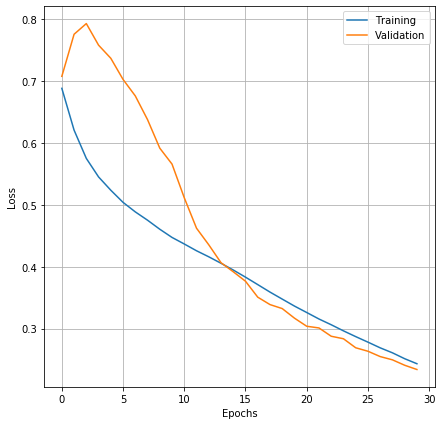

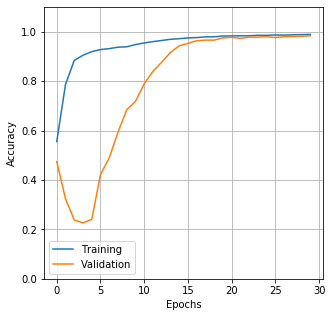

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    139145
           1       0.84      0.83      0.83      4215

    accuracy                           0.99    143360
   macro avg       0.92      0.91      0.91    143360
weighted avg       0.99      0.99      0.99    143360



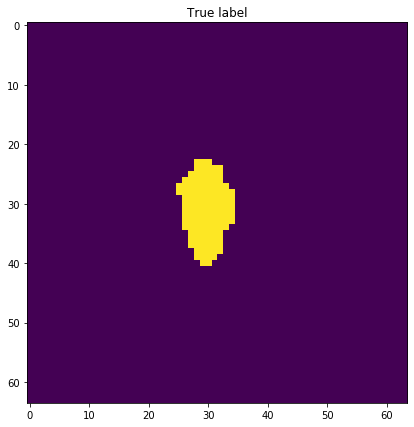

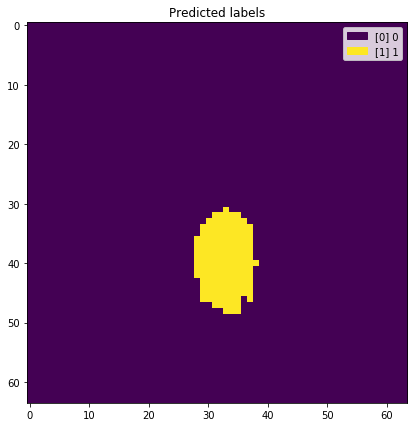

In [155]:
unet = mypackage.MyUnet.UNet(X_train, Y_train)
unet.train(batch_size=5, epochs=30, validation_split=0.1)
unet.plot_training_results()
unet.predict(X_train, Y_labels=Y_train)

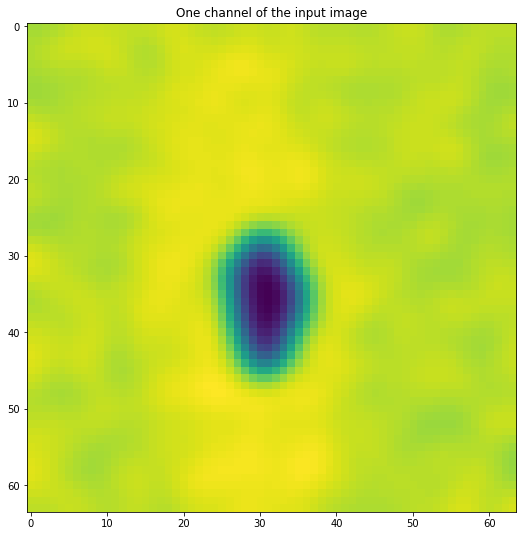

In [154]:
x = X_test[0, :, :, 7]

plt.figure(figsize=(9,9))
img = plt.imshow(x)
plt.title("One channel of the input image")
plt.show()

In [78]:
# x = X_test[0, :, :, 7]

# plt.figure(figsize=(9,9))
# img = plt.imshow(x)
# mypackage.Dataset._Dataset__add_legend_to_image(x, img)
# plt.title("One channel of the input image")
# plt.show()

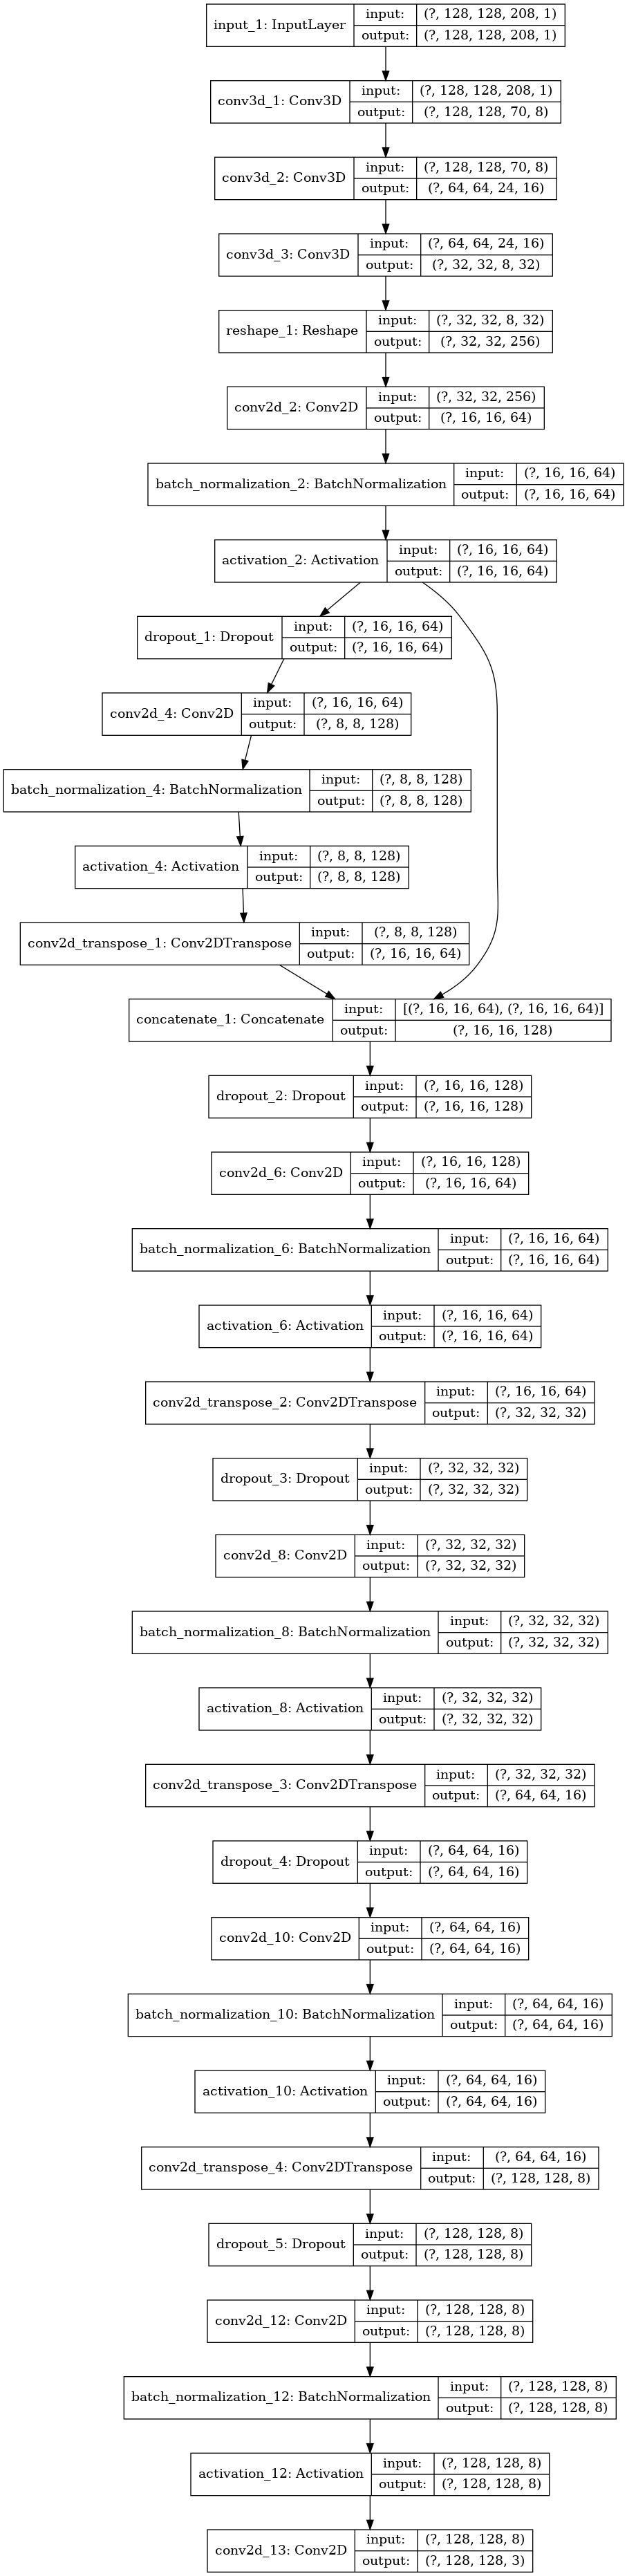

<Figure size 432x288 with 0 Axes>

In [6]:
import tensorflow as tf

plt.figure()
tf.keras.utils.plot_model(unet.model, show_shapes=True);